# Compare different methods for multiobject detection/localization

## general utilities

### load experimental image

In [1]:
import os
import glob


dataset_path = '../data'
image_name='MR16.89_05_1236.tif'
image_path = os.path.join(dataset_path, image_name)

### display image

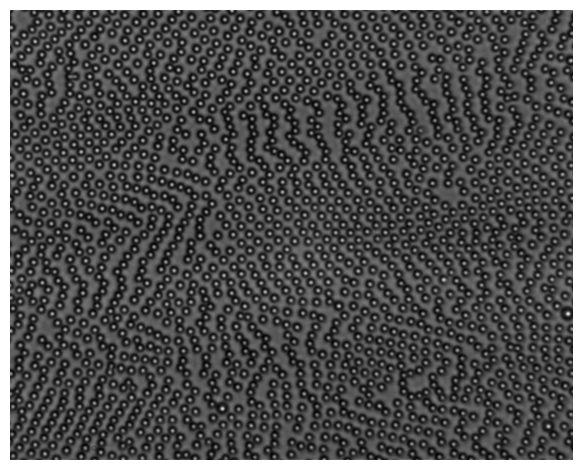

In [2]:
import matplotlib.pyplot as plt
import skimage

plt.figure()

image = skimage.io.imread(image_path)
image=image[:,:,0]

plt.imshow(image, cmap='gray')
plt.axis('off')

plt.tight_layout()
plt.show()

### manually select (and display) single object

/Users/841602/andi-metal/lib/python3.10/site-packages/deeptrack/backend/_config.py:11: UserWarning: cupy not installed. GPU-accelerated simulations will not be possible
  warnings.warn(
/Users/841602/andi-metal/lib/python3.10/site-packages/deeptrack/backend/_config.py:25: UserWarning: cupy not installed, CPU acceleration not enabled
  warnings.warn("cupy not installed, CPU acceleration not enabled")
2023-07-18 12:44:35.940865: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
/Users/841602/andi-metal/lib/python3.10/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_t

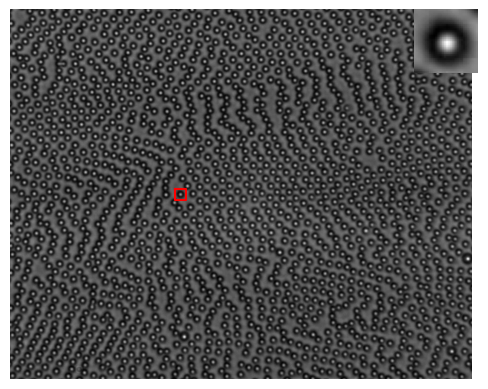

In [3]:
import deeptrack as dt
import numpy as np

width = 30
x = 512 - width // 2
y = 472 - width // 2

crop = image[x:x+width, y:y+width]

fig = plt.figure()


# Draw a red rectangle around the crop
fig.add_subplot(111)
plt.imshow(image, cmap='gray')
plt.plot([y, y+width, y+width, y, y], [x, x, x+width, x+width, x], 'r-')
plt.axis('off')

fig.add_subplot(555)
plt.imshow(crop, cmap='gray')
plt.axis('off')

#plt.savefig('../figures/fig_20_02.png', dpi=300)
plt.show()

## simulate images to test methods' performance

### use deeptrack to recreate image properties

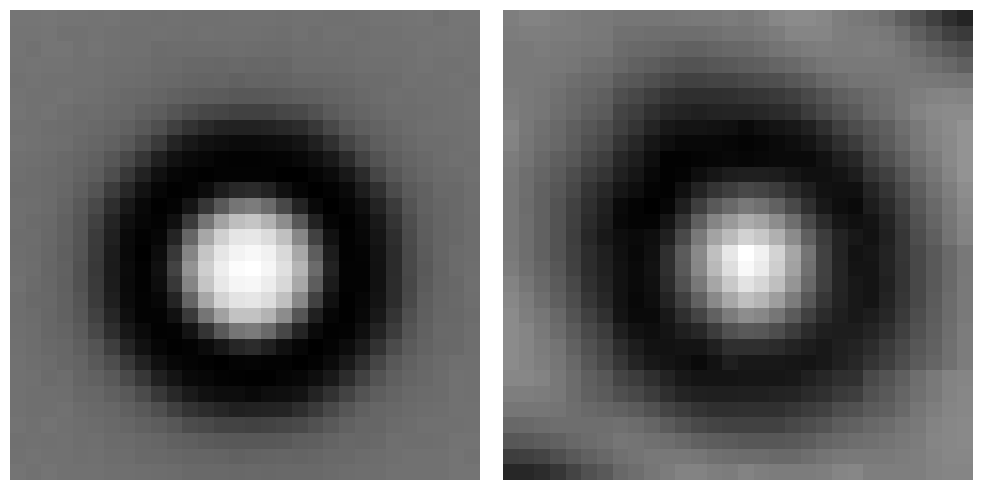

In [4]:
IMAGE_SIZE = 30
from skimage import filters
inner_sphere = dt.Sphere(
        position=lambda: np.random.uniform(
		    IMAGE_SIZE / 2 - 1, 
		    IMAGE_SIZE / 2 + 1, 
		    size=2
	    ),
    radius= 450* dt.units.nm,#lambda: np.random.uniform(0.005e-6, 0.5e-6),
    intensity= 1200,  # Change the intensities here
)
outer_sphere = dt.Sphere(
    position=inner_sphere.position,
    radius=inner_sphere.radius * 2.2,
    inner_intensity=inner_sphere.intensity,
    factor=-0.25,
    intensity=lambda inner_intensity, factor: inner_intensity * factor,
)
combined_sphere = inner_sphere >> outer_sphere

optics = dt.Fluorescence(
    NA= 1.4,  # Numerical aperture
    wavelength= 633. * dt.units.nm,  # Wavelength
    refractive_index_medium= 1.33,
    output_region= [0, 0, IMAGE_SIZE, IMAGE_SIZE],
    magnification= 1,
    resolution= 100* dt.units.nm,  # Wavelength,  # Camera resolution or effective resolution
    return_field = False,
    )

scale_factor = (
    (
        optics.magnification()
        * optics.wavelength()
        / (optics.NA() * optics.resolution())
    )
    ** 2
) * (1 / np.pi)


sim_crop = optics(combined_sphere) >> dt.Divide(scale_factor) >> dt.Add(80) >> dt.Gaussian(0,.5) #>> dt.Lambda( lambda s: lambda x: filters.gaussian(x, sigma=s), s=1.2)

plt.figure(figsize=(10, 5))

plt.subplot(1, 2, 1)
plt.imshow(np.squeeze(sim_crop()), cmap="gray")
plt.axis("off")

plt.subplot(1, 2, 2)
plt.imshow(crop, cmap="gray")

plt.axis("off")

plt.tight_layout()
#plt.savefig('../figures/fig_20_04.png', dpi=300)
plt.show()


### hard spheres simulation
##### we use steepest descent with a modified LJ potential to make sure objects don't overlap

In [5]:
def steepest_descent(pos, gamma=0.01, maxstep=0.001, radius = 5, epsilon=1, DIM = 2, BoxSize = 512):
    sigma = 2* radius
    Rcutoff = (2**(1/6))*sigma
    phicutoff = -epsilon
    N = pos.shape[0]
    acc = np.zeros((N,DIM))
    for i in range(N-1):
        for j in range(i+1,N): #i+1 to N ensures we do not double count
            Sij = pos[i,:]-pos[j,:] # Distance in box scaled units
            for l in range(DIM): # Periodic interactions
                if (np.abs(Sij[l])>0.5):
                    Sij[l] = Sij[l] - np.copysign(1.0,Sij[l]) # If distance is greater than 0.5  (scaled units) then subtract 0.5 to find periodic interaction distance.
            
            Rij = BoxSize*Sij # Scale the box to the real units in this case reduced LJ units
            Rsqij = np.dot(Rij,Rij) # Calculate the square of the distance
            
            if(Rsqij < Rcutoff**2):
                # Calculate LJ potential inside cutoff
                # We calculate parts of the LJ potential at a time to improve the efficieny of the computation (most important for compiled code)
                rm2 = (sigma**2)/Rsqij # 1/r^2
                rm6 = rm2**3.0 # 1/r^6
                rm12 = rm6**2.0 # 1/r^12
                phi = epsilon*(4.0*(rm12-rm6))-phicutoff # 4[1/r^12 - 1/r^6] - phi(Rc) - we are using the shifted LJ potential
                # The following is dphi = -(1/r)(dV/dr)
                dphi = epsilon*24.0*rm2*(2.0*rm12-rm6) # 24[2/r^14 - 1/r^8]
                acc[i,:] = acc[i,:]+dphi*Sij # Accumulate forces
                acc[j,:] = acc[j,:]-dphi*Sij # (Fji=-Fij)

    pos = pos + np.sign(acc)*np.minimum(np.abs(gamma*acc), maxstep ) # Step 1
    fmax = np.max(np.sum(acc**2, axis=1))

    for i in range(DIM):
        pos[:,i]=(pos[:,i]+0.5) % 1. -0.5
        # period = np.where(pos[:,i] > 0.5)
        # pos[period,i]=pos[period,i]-1.0
        # period = np.where(pos[:,i] < -0.5)
        # pos[period,i]=pos[period,i]+1.0 # divmod(pos[period,i],1)[0] #
            
    return pos, fmax

### function to simulate random particle positions and apply steepest descent

In [6]:
def generate_centroids(num_of_particles = [20,21],  BoxSize = 512, DIM = 2, show = False, radius = 5):

    N = np.random.randint(*num_of_particles)

    # initialize positions
    pos = np.random.uniform(-BoxSize/2,BoxSize/2,[N,DIM]) 
    pos = pos[:,:DIM]/BoxSize
    fmax = 1e10
    while fmax>1e2:
        pos,fmax = steepest_descent(pos, gamma=0.01, maxstep=0.001, radius = radius, epsilon=1, DIM = DIM, BoxSize = BoxSize )
        if show == True:
            from IPython import display
            plt.cla()
            plt.xlim(-0.6*BoxSize,0.6*BoxSize)
            plt.ylim(-0.6*BoxSize,0.6*BoxSize)
            for i in range(N):
                c=plt.Circle((pos[i,0]*BoxSize,pos[i,1]*BoxSize), radius=radius, linewidth=1, color='blue', fill=False)
                plt.gca().add_patch(c)
                plt.gca().set_aspect('equal', adjustable='box')
            display.clear_output(wait=True)
            display.display(plt.gcf())
    pos = pos[:,:DIM]*BoxSize + BoxSize/2
    return pos

### hard particles simulation

In [7]:
import numpy as np
import matplotlib.pyplot as plt
gt_pos = generate_centroids(num_of_particles = [30,31],radius= 10, show=False, BoxSize=128)


### function to generate simulated images/videos from coordinates

In [8]:
import imageio

def transform_to_video(
    trajectory_data,
    particle_props={},
    optics_props={},
    background_props={},
    IMAGE_SIZE = [],
    save_video=False,
    maps = True,
    path="",
):
    
    _particle_dict = {
        "z": 0,  # Particles are always at focus
        "position_unit": "pixel",
    }
        
    _optics_dict = {
        "NA": 1.4,  # Numerical aperture
        "wavelength": 633. * dt.units.nm,  # Wavelength
        "refractive_index_medium": 1.33,
        "output_region": [0, 0, IMAGE_SIZE, IMAGE_SIZE],
        "magnification": 1,
        "resolution": 100* dt.units.nm,  # Wavelength,  # Camera resolution or effective resolution
    }

    _optics2_dict = {
        "NA": 1.9,  # Numerical aperture
        "wavelength": 300. * dt.units.nm,  # Wavelength
        "refractive_index_medium": 1.33,
        "output_region": [0, 0, 4*IMAGE_SIZE, 4*IMAGE_SIZE],
        "magnification": 4,
        "resolution": 25* dt.units.nm,  # Wavelength,  # Camera resolution or effective resolution
    }

    # Background offset
    _background_dict = {
        "background_mean": 85,  # Mean background intensity
        "background_std": 0,  # Standard deviation of background intensity within a video
    }
    
    # Update the dictionaries with the user-defined values
    _particle_dict.update(particle_props)
    _optics_dict.update(optics_props)
    _optics2_dict.update(optics_props)
    _background_dict.update(background_props)


    # Reshape the trajectory
    trajectory_data = np.moveaxis(trajectory_data, 0, 1)

    inner_sphere = dt.Sphere(
        trajectories=trajectory_data,
        replicate_index=lambda _ID: _ID,
        trajectory=lambda replicate_index, trajectories: dt.units.pixel
        * trajectories[replicate_index[-1]],
        number_of_particles=trajectory_data.shape[0],
        traj_length=trajectory_data.shape[1],
        position=lambda trajectory: trajectory[0],
        radius= 450* dt.units.nm,#lambda: np.random.uniform(0.005e-6, 0.5e-6),
        intensity= 1200,  # Change the intensities here
        **_particle_dict,
)
    outer_sphere = dt.Sphere(
        trajectories=trajectory_data,
        replicate_index=lambda _ID: _ID,
        trajectory=lambda replicate_index, trajectories: dt.units.pixel
        * trajectories[replicate_index[-1]],
        number_of_particles=trajectory_data.shape[0],
        traj_length=trajectory_data.shape[1],
        position=lambda trajectory: trajectory[0],
        radius=inner_sphere.radius * 2.2,
        inner_intensity=inner_sphere.intensity,
        factor=-0.25,
        intensity=lambda inner_intensity, factor: inner_intensity * factor,
        **_particle_dict,
    )

    prob_map = dt.Sphere(
        trajectories=trajectory_data,
        replicate_index=lambda _ID: _ID,
        trajectory=lambda replicate_index, trajectories: dt.units.pixel
        * trajectories[replicate_index[-1]],
        number_of_particles=trajectory_data.shape[0],
        traj_length=trajectory_data.shape[1],
        position=lambda trajectory: 4*trajectory[0],
        radius= 5 * dt.units.nm,#lambda: np.random.uniform(0.005e-6, 0.5e-6),
        intensity= 1,  # Change the intensities here
        **_particle_dict,
)

    # Make it sequential
    sequential_particle = dt.Sequential(
        inner_sphere,
        position=lambda trajectory, sequence_step: trajectory[sequence_step],
        #intensity=intensity_noise,
    )
    sequential_particle1 = dt.Sequential(
        outer_sphere,
        position=lambda trajectory, sequence_step: trajectory[sequence_step],
        #intensity=intensity_noise,
    )
    
    background = dt.Add(
        value=80
    )  
    def background_variation(previous_values, previous_value):
        return (previous_values or [previous_value])[
            0
        ] + np.random.randn() * _background_dict["background_std"]

    sequential_background = dt.Sequential(background, value=background_variation)


    # Define optical setup
    optics = dt.Fluorescence(**_optics_dict) 

    optics2 = dt.Fluorescence(**_optics2_dict) 

    #optics  = dt.Brightfield(**_optics_dict)

    scale_factor = (
        (
            optics.magnification()
            * optics.wavelength()
            / (optics.NA() * optics.resolution())
        )
        ** 2
        ) * (1 / np.pi)

    # Sample
    sample = (
        optics((sequential_particle >> sequential_particle1) ^ sequential_particle.number_of_particles)     
    ) >> dt.Divide(scale_factor) >> sequential_background >> dt.NormalizeMinMax(0,1)
        
    # Sequential sample
    sequential_sample = dt.Sequence(
        sample,
        trajectory=inner_sphere.trajectories,
        sequence_length=inner_sphere.traj_length,
    )

    # Resolve the sample
    _video = sequential_sample.update().resolve()

    if maps:
        map = (
        optics2((prob_map ) ^ sequential_particle.number_of_particles)     
            ) >>  dt.NormalizeMinMax(0,1) >> dt.AveragePooling((2, 2, 1))

        sequential_map = dt.Sequence(
            map,
            trajectory=inner_sphere.trajectories,
            sequence_length=inner_sphere.traj_length,
            )
        _map = sequential_map.update().resolve()
        final_output = _video, _map
    else:
        final_output = _video

    if save_video:
        if len(final_output) == 2:
            video_8bit = convert_uint8(final_output[0])
        else:
            video_8bit = convert_uint8(final_output)

        imageio.mimwrite(path, video_8bit)

    return final_output

### generate and plot the image

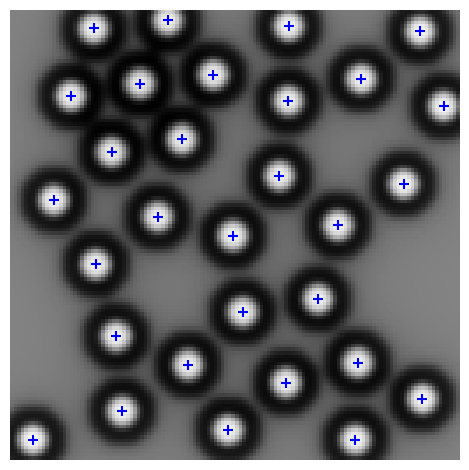

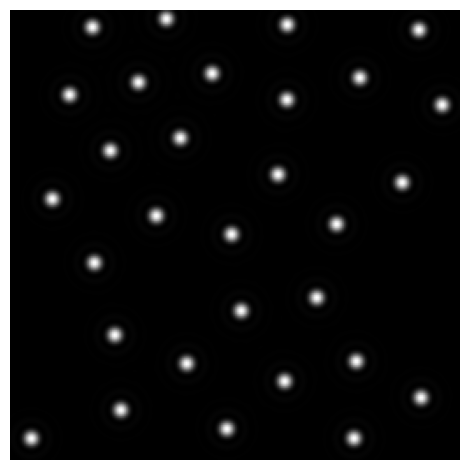

In [9]:
sim_image, sim_map = transform_to_video(gt_pos[np.newaxis, :], IMAGE_SIZE = 128)

plt.figure()

plt.imshow(sim_image, cmap="gray")
plt.scatter(
    gt_pos[:, 1],
    gt_pos[:, 0],
    s=50,
    c="b",
    marker='+'
)
plt.axis("off")

plt.tight_layout()
#plt.savefig('../figures/fig_20_04.png', dpi=300)
plt.show()


plt.figure()

plt.imshow(sim_map, cmap="gray")

plt.axis("off")

plt.tight_layout()
#plt.savefig('../figures/fig_20_04.png', dpi=300)
plt.show()

## Localization and analysis

## First method: thresholding and regionprops

### make a binary mask by thresholding the image

In [10]:
from cv2 import threshold, THRESH_BINARY
_, im_b = threshold(np.array(np.squeeze(sim_image)),0.75, 1, THRESH_BINARY)

### display the mask

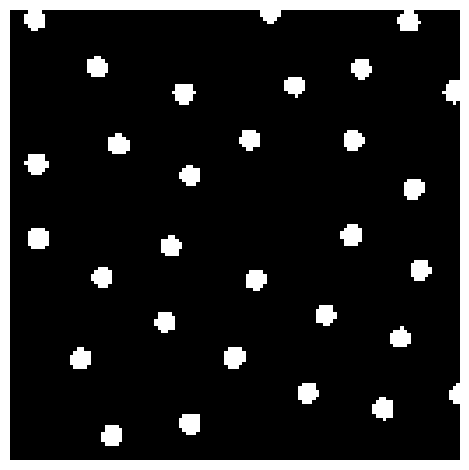

In [11]:
plt.figure()
plt.imshow(im_b, cmap="gray")

plt.axis("off")

plt.tight_layout()
#plt.savefig('../figures/fig_20_04.png', dpi=300)
plt.show()

### function to extract positions from mask

In [12]:
def mask_to_positions(mask):
    from skimage.measure import label, regionprops
    """Converts a mask to a list of positions"""
    # label the mask
    labels = label(mask)
    # get centroids
    props = regionprops(labels)
    return np.array([prop.centroid for prop in props])

### calculate predicted positions

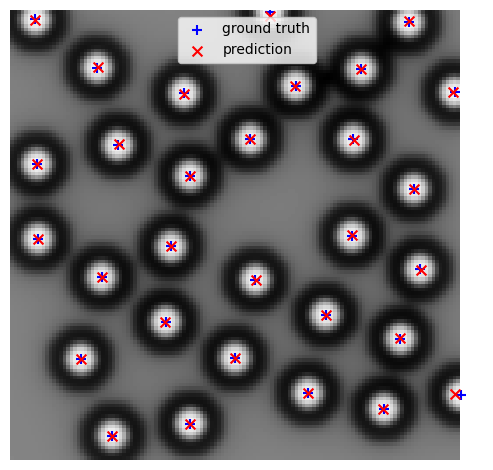

In [13]:
pred_pos_M1 = mask_to_positions(im_b)
plt.figure()

plt.imshow(sim_image, cmap="gray")
plt.scatter(
    gt_pos[:, 1],
    gt_pos[:, 0],
    s=50,
    c="b",
    marker='+',
    label='ground truth'

)

plt.scatter(
    pred_pos_M1[:, 1],
    pred_pos_M1[:, 0],
    s=50,
    c="r",
    marker='x',
    label='prediction'
)
plt.axis("off")
plt.legend()
plt.tight_layout()
#plt.savefig('../figures/fig_20_04.png', dpi=300)
plt.show()

### function to evaluate performance

In [14]:
def evaluate_locs(predicted_positions, true_positions, distance_th = 5):

    import scipy

    TP = 0
    FP = 0
    FN = 0

    distance_matrix = scipy.spatial.distance_matrix(predicted_positions, true_positions)
    row_ind, col_ind = scipy.optimize.linear_sum_assignment(distance_matrix)

    filtered_row_ind = row_ind[distance_matrix[row_ind, col_ind] < distance_th]
    filtered_col_ind = col_ind[distance_matrix[row_ind, col_ind] < distance_th]

    TP += len(filtered_row_ind)
    FP += len(predicted_positions) - len(filtered_row_ind)
    FN += len(true_positions) - len(filtered_col_ind)

    RMSE = sum(distance_matrix[row_ind, col_ind])/TP

    f1 = 2 * TP / (2 * TP + FP + FN)

    print(
        f"""
        TP: {TP}
        FP: {FP}
        FN: {FN}
        F1: {f1}
        RMSE: {RMSE}"""
    )
    return TP, FP, FN, f1, RMSE

### evaluate performance

In [15]:
_,_,_,_,_ = evaluate_locs(pred_pos_M1, gt_pos, distance_th = 5)


        TP: 30
        FP: 0
        FN: 0
        F1: 1.0
        RMSE: 0.23477898618458745


## Extra: Radial simmetry to refine localization

### loop to refine localization with radial simmetry and evaluate performance

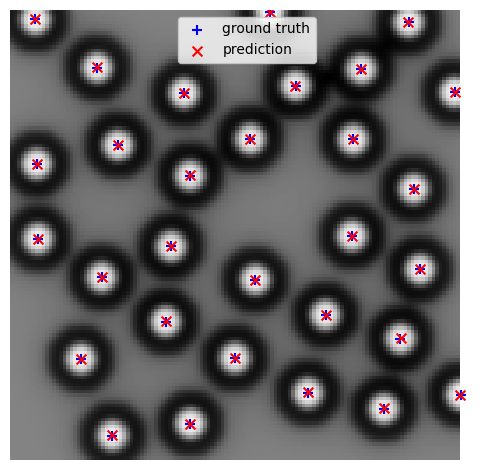


        TP: 30
        FP: 0
        FN: 0
        F1: 1.0
        RMSE: 0.0979592327278935


In [16]:
from deeptrack.extras.radialcenter import radialcenter as rc

roi_size = 24
pred_pos_M1_ref=[]

for x,y in pred_pos_M1:
    roi = sim_image[int(max(0,np.floor(x)-roi_size//2)):int(min(np.floor(x)+roi_size//2,sim_image.shape[0])), int(max(0,np.floor(y)-roi_size//2)):int(min(np.floor(y)+roi_size//2,sim_image.shape[1])),0 ]
    xc, yc = rc(roi, invert_xy=True)
    pred_pos_M1_ref.append([int(max(0,np.floor(x)-roi_size//2))+xc, int(max(0,np.floor(y)-roi_size//2))+yc])


# for x,y in pred_pos_M1:
#     roi = sim_image[max(0,round(x)-roi_size//2):min(round(x)+roi_size//2,sim_image.shape[0]), max(0,round(y)-roi_size//2):min(round(y)+roi_size//2,sim_image.shape[1]) ,0]
#     xc, yc, _, _ = radialcenter(roi)
#     pred_pos_M1_ref.append([max(0,round(x)-roi_size//2)+xc-0.5, max(0,round(y)-roi_size//2)+yc-0.5])

pred_pos_M1_ref=np.array(pred_pos_M1_ref)


plt.figure()

plt.imshow(sim_image, cmap="gray")
plt.scatter(
    gt_pos[:, 1],
    gt_pos[:, 0],
    s=50,
    c="b",
    marker='+',
    label='ground truth'

)

plt.scatter(
    pred_pos_M1_ref[:, 1],
    pred_pos_M1_ref[:, 0],
    s=50,
    c="r",
    marker='x',
    label='prediction'
)
plt.axis("off")
plt.legend()
plt.tight_layout()
#plt.savefig('../figures/fig_20_04.png', dpi=300)
plt.show()

_,_,_,_,_ = evaluate_locs(pred_pos_M1_ref, gt_pos, distance_th = 5)

### apply to experiment

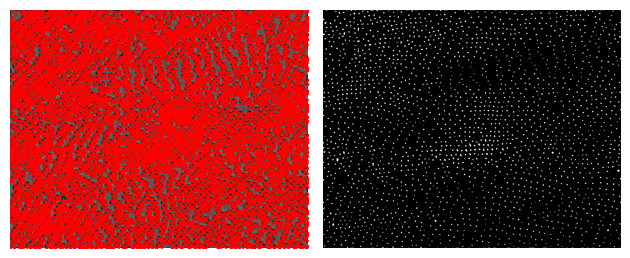

In [17]:
_, im_b = threshold(np.array(np.squeeze(image/255.)),0.4, 1, THRESH_BINARY)

pred_pos_M1_exp = mask_to_positions(im_b)

plt.figure()

plt.subplot(1, 2, 1)
plt.imshow(image, cmap="gray")

plt.scatter(
    pred_pos_M1_exp[:, 1],
    pred_pos_M1_exp[:, 0],
    s=20,
    c="r",
    marker='x',
)
plt.axis("off")
#plt.savefig('../figures/fig_20_04.png', dpi=300)


plt.subplot(1, 2, 2)

plt.imshow(im_b, cmap="gray")

plt.axis("off")

plt.tight_layout()
#plt.savefig('../figures/fig_20_04.png', dpi=300)
plt.show()

## Second method: Crocker and Grier (from trackpy)

### apply, display, and evaluate performance 

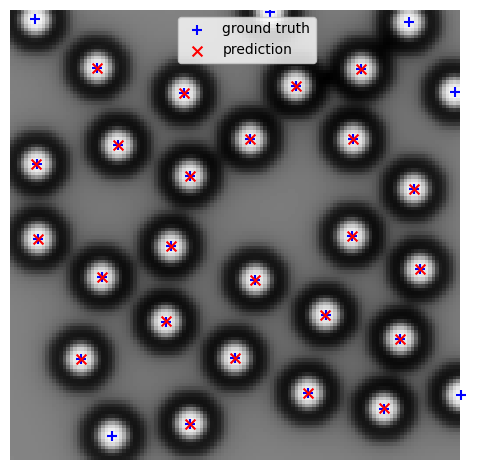


        TP: 24
        FP: 0
        FN: 6
        F1: 0.8888888888888888
        RMSE: 0.029797249652286112


In [18]:
import trackpy as tp
estimated_radius = 15

f = tp.locate(sim_image, estimated_radius, invert=False)
pred_pos_M2 = np.array(f)[:,:2]


plt.figure()
plt.imshow(sim_image, cmap="gray")
plt.scatter(
    gt_pos[:, 1],
    gt_pos[:, 0],
    s=50,
    c="b",
    marker='+',
    label='ground truth'

)

plt.scatter(
    pred_pos_M2[:, 1],
    pred_pos_M2[:, 0],
    s=50,
    c="r",
    marker='x',
    label='prediction'
)
plt.axis("off")
plt.legend()
plt.tight_layout()
#plt.savefig('../figures/fig_20_04.png', dpi=300)
plt.show()

_,_,_,_,_ = evaluate_locs(pred_pos_M2, gt_pos, distance_th = 5)


### apply to experiments

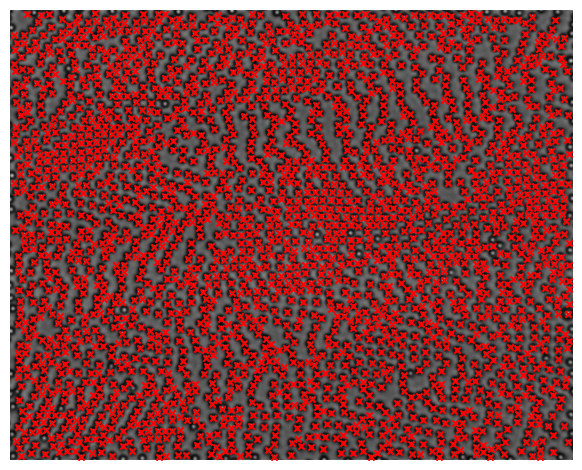

In [19]:
f = tp.locate(image, estimated_radius, invert=False)
pred_pos_M2_exp = np.array(f)[:,:2]


plt.figure()
plt.imshow(image, cmap="gray")


plt.scatter(
    pred_pos_M2_exp[:, 1],
    pred_pos_M2_exp[:, 0],
    s=20,
    c="r",
    marker='x',
)
plt.axis("off")
plt.tight_layout()
#plt.savefig('../figures/fig_20_04.png', dpi=300)
plt.show()


## Method 3: UNet

### create the training dataset

In [ ]:
Nsamples = 32
IM_SIZE=64
images = []
maps = []
for _ in range(Nsamples):
    _gt_pos = generate_centroids(num_of_particles = [5,10],radius= 10, show=False, BoxSize=IM_SIZE)
    _sim_image, _sim_map = transform_to_video(_gt_pos[np.newaxis, :], IMAGE_SIZE = IM_SIZE)
    images.append(_sim_image)
    maps.append(_sim_map)
images=np.array(images)
maps=np.array(maps)


plt.figure(figsize=(10, 5))

plt.subplot(1, 2, 1)
plt.imshow(np.squeeze(images[0]), cmap="gray")
plt.axis("off")

plt.subplot(1, 2, 2)
plt.imshow(np.squeeze(maps[0]), cmap="gray")
plt.axis("off")

plt.axis("off")

plt.tight_layout()
#plt.savefig('../figures/fig_20_04.png', dpi=300)
plt.show()


### define a shallow UNet

In [ ]:
from deeptrack.models import UNet
#from deeptrack.layers import  StaticUpsampleBlock


model = UNet(
    input_shape=(None, None, 1),
    conv_layers_dimensions=(16, 32),
    base_conv_layers_dimensions=(64, 64),
    output_conv_layers_dimensions=(16,),
    output_convolution_block = "deconvolutional",
    output_activation="linear",

)
model.summary()

### compile the model

In [ ]:
from tensorflow.keras.losses import MSE
model.compile(
    loss=MSE,  
    optimizer="adam",
    metrics=["mse"],
    )

### training pipeline and generator

In [ ]:
selector = dt.Lambda(lambda i: lambda x: x[i],  i = lambda l: np.random.randint(l), l=len(images))

pipeline  = (dt.Value(images) & dt.Value(maps))  >> dt.NormalizeMinMax(0,1)  >> selector

generator = dt.generators.ContinuousGenerator(
    pipeline,
    min_data_size=int(64), 
    max_data_size=int(65),
    batch_size=8,
)

### check pipeline

In [ ]:
test, t_map = pipeline.update()()
plt.figure(figsize=(15, 5))

plt.subplot(1, 2, 1)
plt.imshow(test, cmap='gray')

plt.axis('off')


plt.subplot(1, 2, 2)
plt.imshow(t_map, cmap='gray')
plt.axis('off')

plt.tight_layout()
#plt.savefig('../figures/fig_20_03.png', dpi=300)
plt.show()

### train the UNet

In [ ]:
with generator:
    model.fit(
        generator,
        epochs=30, 
    )

### alternative training

In [ ]:
  model.fit(
    pipeline,
    epochs=100, 
    batch_size = 8,
    generator_kwargs={
    "min_data_size": int(64),
    "max_data_size": int(65),
  } 
)

### test and evaluation

In [ ]:
#test, t_map = pipeline.update()()
from deeptrack.extras.radialcenter import radialcenter  as rc

pred_map = model.predict(sim_image[np.newaxis])
pred_map = np.array(np.squeeze(pred_map))
_, im_b = threshold(pred_map,0.1, 1, THRESH_BINARY)
pred_pos_M3 = mask_to_positions(im_b)
_,_,_,_,_ = evaluate_locs(pred_pos_M3/2, gt_pos, distance_th = 5)

#
roi_size = 31
pred_pos_M3_ref=[]
for x,y in pred_pos_M3:
    roi = sim_map[int(max(0,np.floor(x)-roi_size//2)):int(min(np.floor(x)+roi_size//2,sim_map.shape[0])), int(max(0,np.floor(y)-roi_size//2)):int(min(np.floor(y)+roi_size//2,sim_map.shape[1])) ]
    xc, yc = rc(roi, invert_xy=True)
    pred_pos_M3_ref.append([int(max(0,np.floor(x)-roi_size//2))+xc, int(max(0,np.floor(y)-roi_size//2))+yc])

pred_pos_M3_ref=np.array(pred_pos_M3_ref)

_,_,_,_,_ = evaluate_locs(pred_pos_M3_ref/2, gt_pos, distance_th = 5)


### display

In [ ]:
plt.figure(figsize=(15, 5))

plt.subplot(1, 3, 1)
plt.imshow(sim_image, cmap='gray')
plt.scatter(
   gt_pos[:,1],
   gt_pos[:,0], 
   s=50,
   c="b",
   marker='+',
   label='ground truth'
)
plt.scatter(
    pred_pos_M3_ref[:, 1]/2,
    pred_pos_M3_ref[:, 0]/2,
    s=50,
    c="r",
    marker='x',
    label='prediction'
)

plt.axis('off')
plt.legend()

plt.subplot(1, 3, 2)
plt.imshow(im_b, cmap='gray')
plt.axis('off')
#plt.text(5, 15, 'b', fontsize=20, fontweight='bold', color='white')


plt.subplot(1, 3, 3)
plt.imshow(pred_map, cmap='gray')
plt.axis('off')
plt.tight_layout()


plt.scatter(
    pred_pos_M3_ref[:, 1],
    pred_pos_M3_ref[:, 0],
    s=50,
    c="r",
    marker='x',
    label='prediction'
)
plt.axis('off')


plt.tight_layout()
#plt.savefig('../figures/fig_20_03.png', dpi=300)
plt.show()

### apply to experiments

In [ ]:
normalization = dt.NormalizeMinMax(0,1)
pred = model.predict(np.reshape(normalization(image), (1, image.shape[0],image.shape[1], 1)))
pred = np.array(np.squeeze(pred))
_, im_b = threshold(pred,0.01, 1, THRESH_BINARY)
pred_pos_M3_exp = mask_to_positions(im_b)/2

plt.figure(figsize=(15, 5))
plt.subplot(1, 2, 1)
plt.imshow(image, cmap='gray')
#plt.imshow(pred, cmap='gray')

plt.scatter(
    pred_pos_M3_exp[:, 1],
    pred_pos_M3_exp[:, 0],
    s=20,
    c="r",
    marker='x',
    label='prediction'
)
plt.axis('off')

plt.subplot(1, 2, 2)
plt.imshow(im_b, cmap='gray')
plt.axis('off')

plt.tight_layout()
#plt.savefig('../figures/fig_20_03.png', dpi=300)
plt.show()


## Method 4: Lodestar

### define one-shot training set and augmentation

In [10]:

augmentations = optics(combined_sphere) >> dt.Divide(lambda: scale_factor*np.random.uniform(.9, 1.1))  >> dt.Add(lambda: 80 + np.random.uniform(-5, 5)) >> dt.Gaussian(0,.5)
normalization = dt.Divide(255)


training_pipeline = augmentations >> normalization

### check augmentations

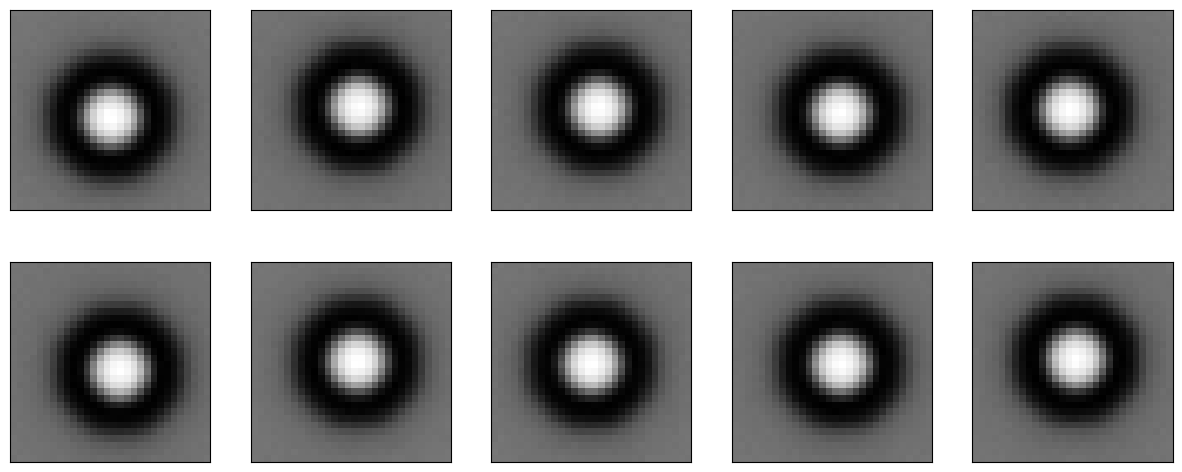

In [11]:

fig, axes = plt.subplots(2, 5, figsize=(15, 6))

for i, ax in enumerate(axes.flatten()):
    sim=training_pipeline.update()()
    ax.imshow(np.squeeze(sim), cmap="gray")
    ax.set_xticks([])
    ax.set_yticks([])



### define model and train

In [12]:
model = dt.models.LodeSTAR()

model.fit(
	training_pipeline,
	epochs=50,
	batch_size=8,
	steps_per_epoch=100,
)

2023-07-18 12:45:37.037308: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-07-18 12:45:37.038030: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:306] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
2023-07-18 12:45:37.038090: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-07-18 12:45:37.038448: I tensorflow/core/common_runtime/pluggable_device/plug

Metal device set to: AMD Radeon Pro Vega 20

systemMemory: 32.00 GB
maxCacheSize: 1.99 GB

Generating 165 / 160 samples before starting training
Epoch 1/50


2023-07-18 12:45:50.086123: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


100/100 [==============================] - 9s 52ms/step - total_loss: 1.9068 - consistency_loss: 0.9974
Epoch 2/50
100/100 [==============================] - 5s 53ms/step - total_loss: 0.8819 - consistency_loss: 0.5597
Epoch 3/50
100/100 [==============================] - 5s 51ms/step - total_loss: 0.3710 - consistency_loss: 0.1981
Epoch 4/50
100/100 [==============================] - 5s 52ms/step - total_loss: 0.0925 - consistency_loss: 0.0270
Epoch 5/50
100/100 [==============================] - 5s 54ms/step - total_loss: 0.0804 - consistency_loss: 0.0128
Epoch 6/50
100/100 [==============================] - 7s 66ms/step - total_loss: 0.0695 - consistency_loss: 0.0104
Epoch 7/50
100/100 [==============================] - 7s 68ms/step - total_loss: 0.0571 - consistency_loss: 0.0088
Epoch 8/50
100/100 [==============================] - 7s 71ms/step - total_loss: 0.0531 - consistency_loss: 0.0072
Epoch 9/50
100/100 [==============================] - 7s 66ms/step - total_loss: 0.0518 - c

KeyboardInterrupt: 

### save/load model

In [13]:
model.save_weights("lodestar/weights")
#model.load_weights("weights")

### pick image for test and predict features

In [14]:
test_image = np.reshape(sim_image, (1, sim_image.shape[0],sim_image.shape[1], 1))

position_feature, mass_feature = model.predict(test_image)

2023-07-18 12:49:26.465650: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


1/1 [==============================] - 1s 502ms/step


### display predicted features

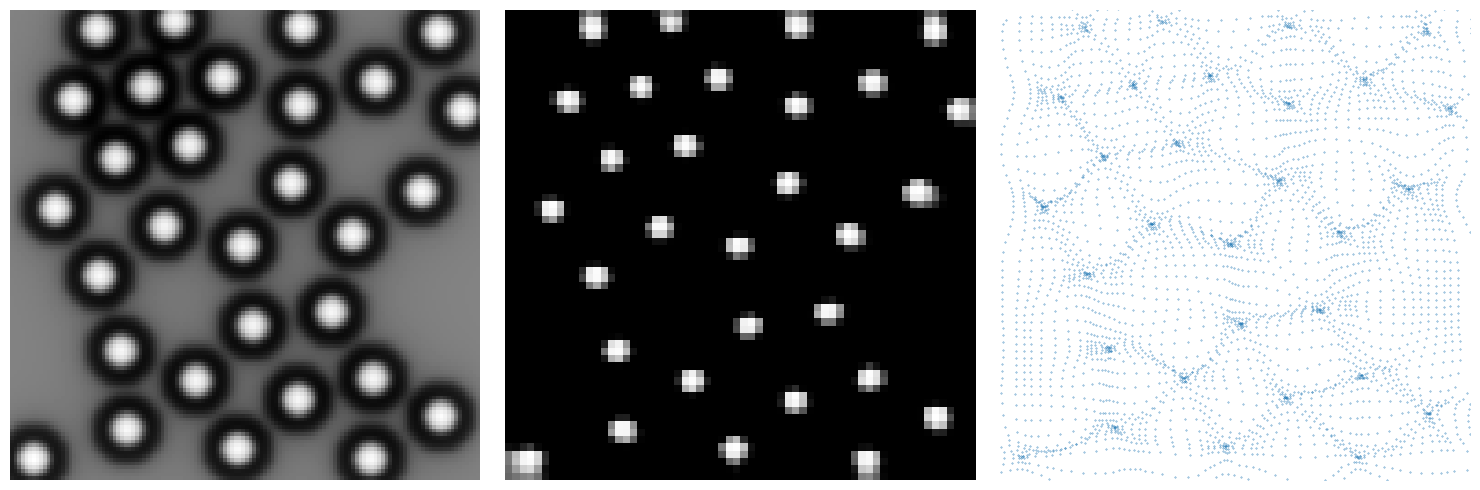

In [15]:
plt.figure(figsize=(15, 5))


plt.subplot(1, 3, 1)
plt.imshow(sim_image, cmap='gray')
plt.axis('off')

plt.subplot(1, 3, 2)
plt.imshow(mass_feature[0], cmap='gray')
plt.axis('off')
#plt.text(5, 15, 'b', fontsize=20, fontweight='bold', color='white')

plt.subplot(1, 3, 3)
plt.scatter(
   position_feature[0, :, :, 1].flatten(),
   position_feature[0, :, :, 0].flatten(), 
   alpha=0.9,
   s=.1,
)
plt.xlim(0, sim_image.shape[0])
plt.ylim(0, sim_image.shape[1])
plt.gca().invert_yaxis()
plt.gca().set_aspect('equal', adjustable='box')
#plt.text(10, 30, 'c', fontsize=20, fontweight='bold', color='black')
plt.axis('off')

plt.tight_layout()
#plt.savefig('../figures/fig_20_03.png', dpi=300)
plt.show()

### predict positions

In [16]:
pred_pos_M4 = model.predict_and_detect(
    test_image, 
    alpha=0.1,
    beta=0.9,
    mode = 'constant',
    cutoff=0.1
)[0]

1/1 [==============================] - 0s 40ms/step


### overlay detections to test image

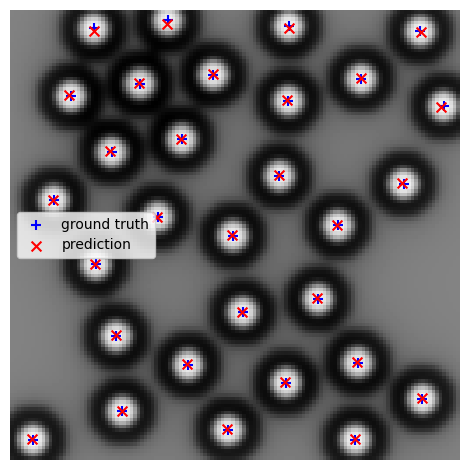

NameError: name 'evaluate_locs' is not defined

In [18]:
plt.figure()
plt.imshow(sim_image, cmap="gray")
plt.scatter(
    gt_pos[:, 1],
    gt_pos[:, 0],
    s=50,
    c="b",
    marker='+',
    label='ground truth'
)

plt.scatter(
    pred_pos_M4[:, 1],
    pred_pos_M4[:, 0],
    s=50,
    c="r",
    marker='x',
    label='prediction'
)
plt.axis("off")
plt.legend()
plt.tight_layout()
#plt.savefig('../figures/fig_20_04.png', dpi=300)
plt.show()

_,_,_,_,_ = evaluate_locs(pred_pos_M4, gt_pos, distance_th = 5)


### transfer learning to experimental image

In [19]:
pred_pos_M4_exp = model.predict_and_detect(
    np.reshape(normalization(image), (1, image.shape[0],image.shape[1], 1)), 
    alpha=0.1,
    beta=0.9,
    mode = 'constant',
    cutoff=0.1
)[0]

2023-07-18 12:49:52.634616: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


1/1 [==============================] - 0s 394ms/step


### display


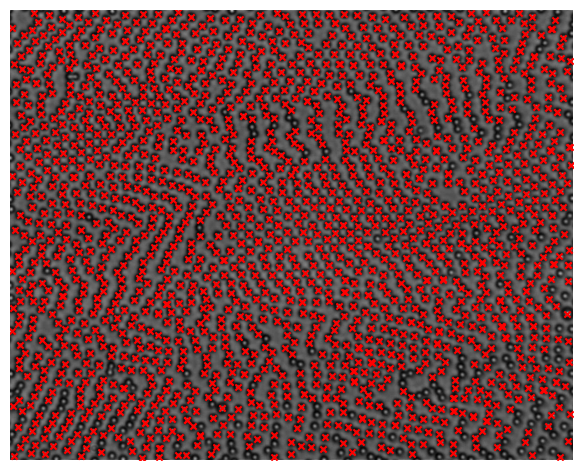

In [20]:
plt.figure()

plt.imshow(image, cmap="gray")
plt.scatter(
    pred_pos_M4_exp[:, 1],
    pred_pos_M4_exp[:, 0],
    s=20,
    c="r",
    marker='x'
)
plt.axis("off")

plt.tight_layout()
#plt.savefig('../figures/fig_20_04.png', dpi=300)
plt.show()

### Lodestar needs only one experimental image

In [30]:
normalization = dt.Divide(255)
value = dt.Value(lambda: np.array(crop))

augmentations = (
    dt.FlipLR() >> dt.FlipUD() >>dt.FlipDiagonal()
    >> dt.Multiply(lambda: np.random.uniform(0.8, 1.2))
    >> dt.Add(lambda: np.random.uniform(-0.1, 0.1))
    
)

training_pipeline = value >> normalization >> augmentations

### check augmentation

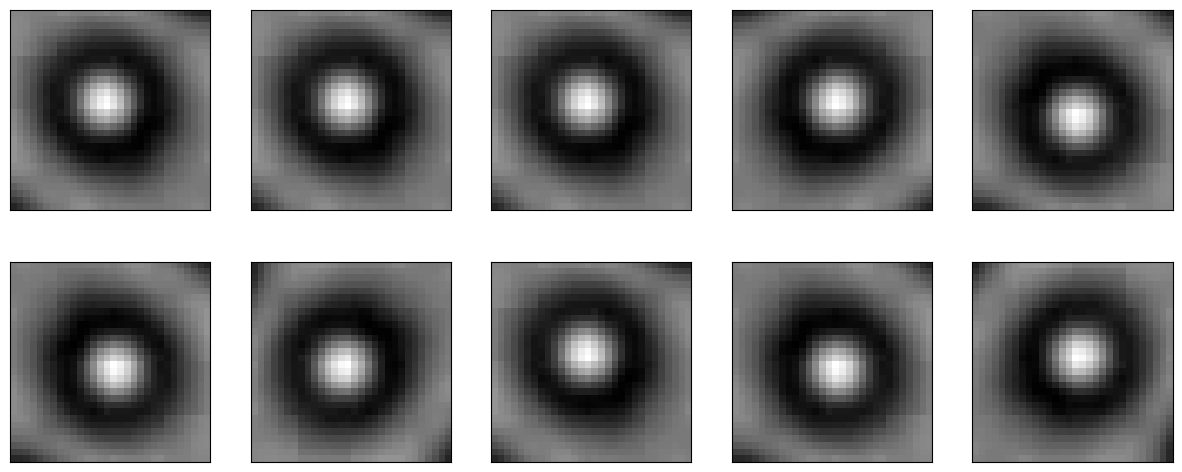

In [31]:
fig, axes = plt.subplots(2, 5, figsize=(15, 6))

for i, ax in enumerate(axes.flatten()):
    sim=training_pipeline.update()()
    ax.imshow(np.squeeze(sim), cmap="gray")
    ax.set_xticks([])
    ax.set_yticks([])

In [32]:
model2 = dt.models.LodeSTAR()

model2.fit(
	training_pipeline,
	epochs=50,
	batch_size=8,
	steps_per_epoch=100,
)

Generating 160 / 160 samples before starting training
Epoch 1/50


2023-07-18 12:41:33.085622: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


100/100 [==============================] - 12s 52ms/step - total_loss: 2.4095 - consistency_loss: 1.0886
Epoch 2/50
100/100 [==============================] - 6s 59ms/step - total_loss: 1.0693 - consistency_loss: 0.7276
Epoch 3/50
100/100 [==============================] - 7s 66ms/step - total_loss: 0.9026 - consistency_loss: 0.4061
Epoch 4/50
100/100 [==============================] - 6s 60ms/step - total_loss: 0.1364 - consistency_loss: 0.0296
Epoch 5/50
100/100 [==============================] - 7s 71ms/step - total_loss: 0.1007 - consistency_loss: 0.0122
Epoch 6/50
100/100 [==============================] - 8s 76ms/step - total_loss: 0.0588 - consistency_loss: 0.0087
Epoch 7/50
100/100 [==============================] - 6s 63ms/step - total_loss: 0.0580 - consistency_loss: 0.0071
Epoch 8/50
100/100 [==============================] - 7s 72ms/step - total_loss: 0.0559 - consistency_loss: 0.0076
Epoch 9/50
100/100 [==============================] - 7s 74ms/step - total_loss: 0.0461 - 

KeyboardInterrupt: 

### predict coordinates

In [33]:
pred_pos_M4_exp2 = model2.predict_and_detect(
    np.reshape(normalization(image), (1, image.shape[0],image.shape[1], 1)), 
    alpha=0.1,
    beta=0.9,
    mode = 'constant',
    cutoff=0.1
)[0]

2023-07-18 12:42:56.283793: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


1/1 [==============================] - 0s 416ms/step


### display results

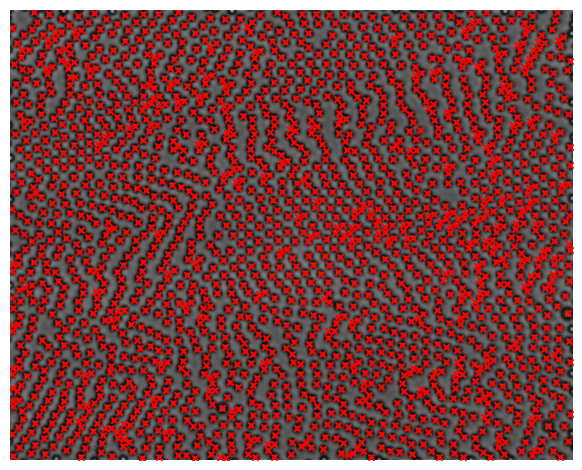

In [34]:
plt.figure()

plt.imshow(image, cmap="gray")
plt.scatter(
    pred_pos_M4_exp2[:, 1],
    pred_pos_M4_exp2[:, 0],
    s=20,
    c="r",
    marker='x'
)
plt.axis("off")

plt.tight_layout()
#plt.savefig('../figures/fig_20_04.png', dpi=300)
plt.show()

### in same cases, it might be necessary to use multiple image crops

### select the crops interactively

In [35]:
import matplotlib
matplotlib.use('Qt5Agg')
import matplotlib.pyplot as plt

crops=np.empty([0,width,width])

plt.figure(figsize=(12, 12))
plt.imshow(image, cmap="gray")
plt.axis("off")
x=plt.ginput(n=-1, timeout=-1,show_clicks=True)


for i, val in enumerate(x):
    crops=np.append(crops, np.array([image[int(val[1])-width//2:int(val[1])+width//2, int(val[0])-width//2:int(val[0])+width//2]]),0)


: 

### checks crops

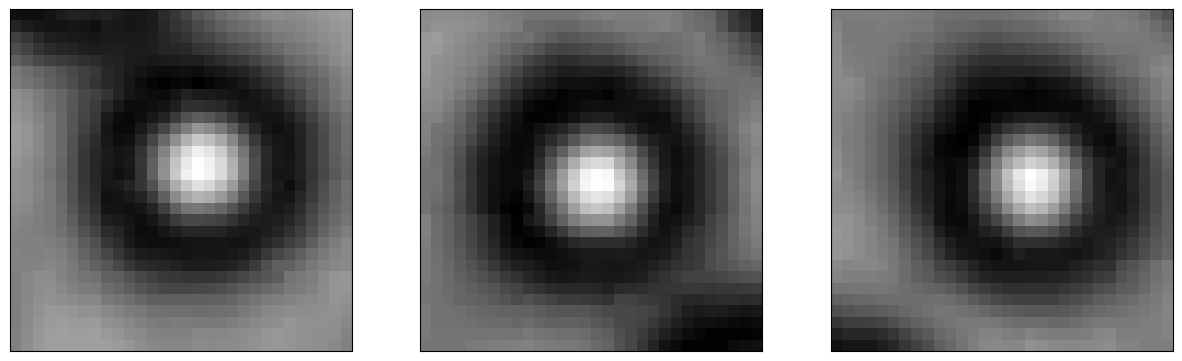

In [31]:
%matplotlib inline
fig, axes = plt.subplots(1, crops.shape[0], figsize=(15, 6))

for i, ax in enumerate(axes.flatten()):
    ax.imshow(np.squeeze(crops[i,:,:]), cmap="gray")
    ax.set_xticks([])
    ax.set_yticks([])


### apply augmentation to crops

In [42]:
import random

augmentations_crops = (
    dt.Value(lambda:random.choice(crops)) 
    >> dt.Divide(255)
    >> dt.FlipLR() >> dt.FlipUD() >>dt.FlipDiagonal()
    >> dt.Multiply(lambda: np.random.uniform(0.8, 1.2))
    >> dt.Add(lambda: np.random.uniform(-0.1, 0.1))
    
)

### check augmentation to crops

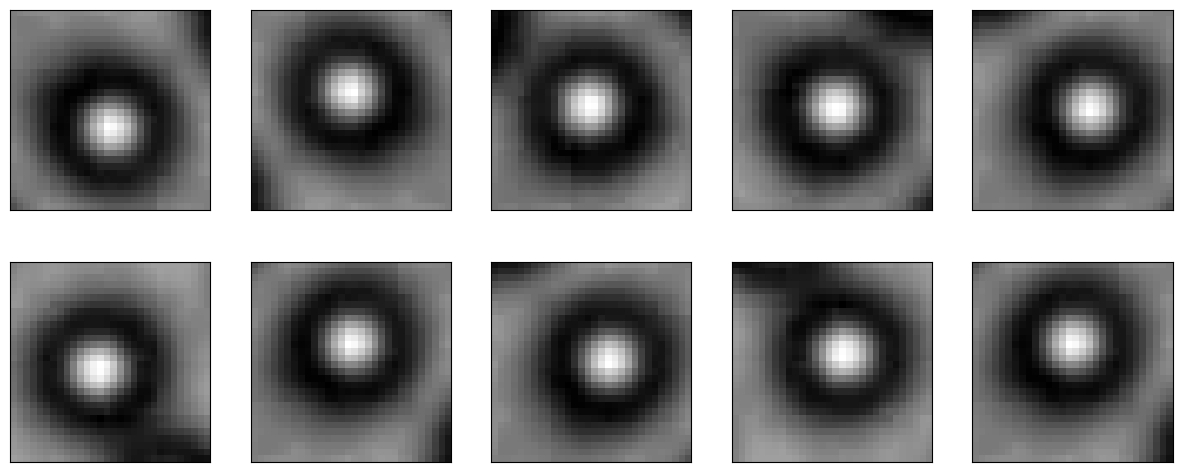

In [43]:
fig, axes = plt.subplots(2, 5, figsize=(15, 6))

for i, ax in enumerate(axes.flatten()):
    aug_crop=augmentations_crops.update()()
    ax.imshow(np.squeeze(aug_crop), cmap="gray")
    ax.set_xticks([])
    ax.set_yticks([])

In [44]:
model3 = dt.models.LodeSTAR()

model3.fit(
	augmentations_crops,
	epochs=50,
	batch_size=8,
	steps_per_epoch=100,
)

Metal device set to: AMD Radeon Pro Vega 20

systemMemory: 32.00 GB
maxCacheSize: 1.99 GB



2023-07-06 16:06:03.457721: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-07-06 16:06:03.458495: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:306] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
2023-07-06 16:06:03.458552: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-07-06 16:06:03.458819: I tensorflow/core/common_runtime/pluggable_device/plug

Generating 167 / 160 samples before starting training
Epoch 1/50


2023-07-06 16:06:14.680140: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


100/100 [==============================] - 12s 46ms/step - total_loss: 2.1722 - consistency_loss: 1.0572
Epoch 2/50
100/100 [==============================] - 6s 63ms/step - total_loss: 1.5065 - consistency_loss: 0.7311
Epoch 3/50
100/100 [==============================] - 6s 65ms/step - total_loss: 2.5785 - consistency_loss: 1.0777
Epoch 4/50
100/100 [==============================] - 6s 55ms/step - total_loss: 1.7997 - consistency_loss: 0.7261
Epoch 5/50
100/100 [==============================] - 6s 59ms/step - total_loss: 2.3850 - consistency_loss: 0.6172
Epoch 6/50
100/100 [==============================] - 6s 61ms/step - total_loss: 2.0453 - consistency_loss: 0.4245
Epoch 7/50
100/100 [==============================] - 5s 54ms/step - total_loss: 1.0600 - consistency_loss: 0.3266
Epoch 8/50
100/100 [==============================] - 6s 64ms/step - total_loss: 0.5096 - consistency_loss: 0.1884
Epoch 9/50
100/100 [==============================] - 6s 64ms/step - total_loss: 0.3481 - 

KeyboardInterrupt: 

### predict coordinates

In [46]:
normalization = dt.Divide(255)

pred_pos_M4_exp3 = model3.predict_and_detect(
    np.reshape(normalization(image), (1, image.shape[0],image.shape[1], 1)), 
    alpha=0.1,
    beta=0.9,
    mode = 'constant',
    cutoff=0.1
)[0]

2023-07-06 16:09:14.097316: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


1/1 [==============================] - 0s 484ms/step


### display results

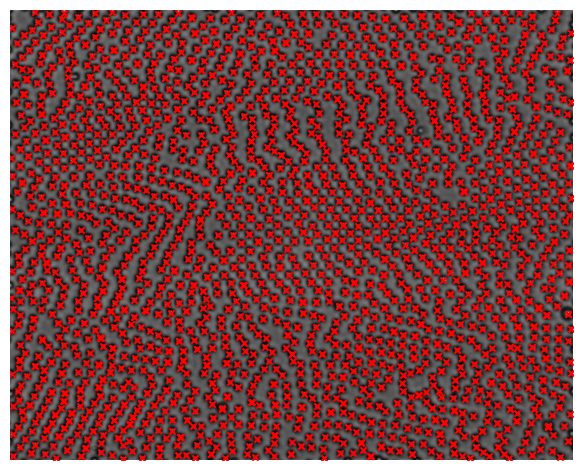

: 

In [47]:
plt.figure()

plt.imshow(image, cmap="gray")
plt.scatter(
    pred_pos_M4_exp3[:, 1],
    pred_pos_M4_exp3[:, 0],
    s=20,
    c="r",
    marker='x'
)
plt.axis("off")

plt.tight_layout()
#plt.savefig('../figures/fig_20_04.png', dpi=300)
plt.show()